In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve

In [3]:
train = pd.read_csv("train.csv")
submission = pd.read_csv("example_sample_submission.csv")       
features = pd.read_csv("features.csv")       
examples = pd.read_csv("example_test.csv")

In [4]:
def AddRemoveColsNewColumns(train):
    # Columns dropped her is hard coded for testing, I picked these columns using EDA insights,
    train.drop(["feature_129","feature_78","feature_102","feature_90","feature_114","feature_78","feature_74","feature_92","feature_80","feature_104","feature_116","feature_125","feature_99","feature_93","feature_117","feature_75","feature_81","feature_3","feature_45","feature_4","feature_109"], axis = 1, inplace = True) 
    train.drop(["date","weight","resp_1","resp_2","resp_3","resp_4"], axis = 1, inplace = True) 
    #drop null over 10% and no relation to resp fields
    nulls = train.isnull().sum()
    nulls_list = list(nulls[nulls >(0.1 * len(train))].index)
    train.drop(columns=nulls_list,inplace=True)
    return train

In [5]:
def DoPCA(train):
    return train

In [6]:
def DoTransformation(train):
    # write code here to do any transformations and returned the transformed 
    # Remove outliers
    # Hard code her just to test code
    train.fillna(train.mean())
    features = train.columns.tolist()
    return train, features

In [7]:
def print_score(pred, y_test):
    print('accuracy: {:.4}'.format(accuracy_score(pred, y_test)))
    print('precision: {:.4}'.format(precision_score(pred, y_test)))
    print('recall: {:.4}'.format(recall_score(pred, y_test)))
    print('f1: {:.4}'.format(f1_score(pred, y_test)))
    print('auc: {:.4}'.format(roc_auc_score(pred, y_test)))

In [8]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [13]:
def initalise():
    # Reduce the memory
    train = pd.read_csv("train.csv")
    train = reduce_memory_usage(train)

    # Create the action Column
    train['action']=0
    train.loc[train['resp']>0.0,'action']=1
    train_df = train[train['date']>85]

    # Add new columns & do transformation
    train = AddRemoveColsNewColumns(train)
    train = DoPCA (train)
    train,features = DoTransformation (train)
    return train, features

In [10]:
def GetFeatureImportance (train):
# Remove the first 85 days data as it was quite volitaile
 

    # set the action as target
    train_target = train['action']
    lgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': -1,
        'num_leaves': 300,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_lambda': 0.3,
        'reg_alpha': 0.3
    }

    lgb_clf = LGBMClassifier(n_jobs=-1)
    lgb_clf.fit(train, train_target)
    ftr_importances_values = lgb_clf.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=train.columns)
    ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

    plt.figure(figsize=(12,8))
    plt.title('Feature importances top 30')
    sns.barplot(x=ftr_top30, y=ftr_top30.index)
    plt.show()
    del train
    gc.collect()
    return lgb_clf

In [11]:
def Kaggle_Prediction (model,features):
    env = janestreet.make_env() # initialize the environment 
    iter_test = env.iter_test() # an iterator which loops over the test set

    for (test_df, sample_prediction_df) in iter_test: 
        sample_prediction_df.action = model.predict(test_df[features])
        env.predict(sample_prediction_df)

Memory usage of dataframe is 2516.843978881836 MB
Memory usage of dataframe after reduction 1247.0233011245728 MB
Reduced by 50.45289610369131 % 


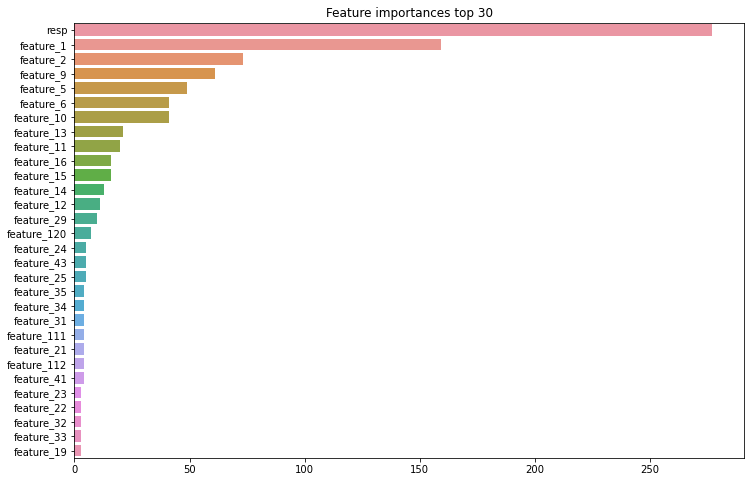

NameError: name 'gc' is not defined

In [49]:
train,features = initalise()
model=GetFeatureImportance (train)
#Kaggle_Prediction (model,features)

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
clf = RandomForestClassifier()

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
imp = SimpleImputer()

In [27]:
X = train.drop('action', axis=1)
y = train['action']

In [54]:
features

['resp',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_5',
 'feature_6',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'feature_66',
 'feature_67',
 'feature_68',
 'feature_69',
 'feature_70',
 'feature_71',
 'feature_73',
 'feature_76',
 'feature_77',
 'featu

In [28]:
X = imp.fit_transform(X)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
clf.score(X_train, y_train)

1.0

In [51]:
cls

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
import pickle

pickle.dump(clf, open('rfc_model.sav', 'wb'))
pickle.dump(cls, open('xgb_model.sav', 'wb'))
pickle.dump(reg, open('reg_model.sav', 'wb'))


In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
reg = LogisticRegression()

In [38]:
reg.fit(X_train, y_train)

LogisticRegression()

In [39]:
reg.score(X_train, y_train)

0.5039238817146275

In [45]:
reg.score(X_test, y_test)

0.5046507104177168

In [42]:
from xgboost.sklearn import XGBClassifier

In [43]:
cls = XGBClassifier()

In [44]:
cls.fit(X_train, y_train)

C:\Users\oolus\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
cls.score(X_train, y_train)

1.0

In [47]:
cls.score(X_test, y_test)

1.0

In [48]:
Kaggle_Prediction (model,features)

NameError: name 'model' is not defined